In [22]:
!pip install evaluate

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
from datasets import Dataset, DatasetDict

print(tf.__version__)
print(tf.config.list_physical_devices())

# startegy for training on parallel gpus
mirrored_strategy = tf.distribute.MirroredStrategy()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')
X,y = dataset["uttr"], dataset["eb+_emot"]

print(X.head(5))
print(type(X), end="\n\n")
print(y.head(5))
print(type(y), end="\n\n")

classes = y.unique()
classes

0    You moron ! What fool washes diapers by the we...
1                                   You useless fool !
2                                 How dare you sleep !
3                        Up ! Go and clean the house .
4                                  Clean the kitchen .
Name: uttr, dtype: object
<class 'pandas.core.series.Series'>

0       angry
1     furious
2     furious
3    prepared
4    prepared
Name: eb+_emot, dtype: object
<class 'pandas.core.series.Series'>



array(['angry', 'furious', 'prepared', 'acknowledging', 'trusting',
       'confident', 'hopeful', 'caring', 'sentimental', 'anticipating',
       'wishing', 'surprised', 'ashamed', 'questioning', 'sad',
       'nostalgic', 'devastated', 'terrified', 'embarrassed', 'lonely',
       'encouraging', 'suggesting', 'content', 'afraid', 'impressed',
       'agreeing', 'apprehensive', 'proud', 'annoyed', 'anxious',
       'grateful', 'excited', 'neutral', 'faithful', 'guilty',
       'consoling', 'disgusted', 'disappointed', 'jealous', 'joyful',
       'sympathizing'], dtype=object)

# Preparation

In [5]:
# fix OCR errors
correct = False

if correct:
    list_X = X.to_list()
    for i in tqdm(range(len(list_X))):
        uttr = list_X[i]
        words = uttr.split(" ")
        filtered_words = []
        for word in words:
            #filtering away all numbers -> not good
            if all(char.isalpha() for char in word):
                filtered_words.append(word)
        list_X[i] = ' '.join(filtered_words)
    X = pd.Series(list_X)

X.head(5)

0    You moron ! What fool washes diapers by the we...
1                                   You useless fool !
2                                 How dare you sleep !
3                        Up ! Go and clean the house .
4                                  Clean the kitchen .
Name: uttr, dtype: object

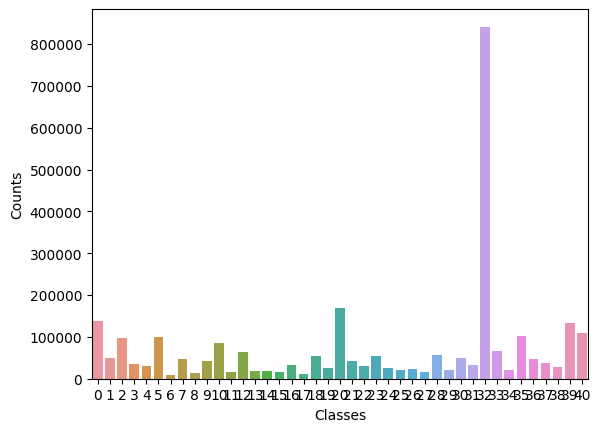

In [6]:
# plot classes distribution
counts = pd.get_dummies(y).sum()

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = [i for i in range(len(classes))], y = counts)
plt.show()

In [7]:
# train, validation and test split
train_X, no_train_X, train_y, no_train_y = train_test_split(X, y, test_size=0.3, stratify=y)
test_X, valid_X, test_y, valid_y = train_test_split(no_train_X, no_train_y, test_size=0.5, stratify=no_train_y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))
print("test size: ", len(test_X))

train size:  1980598
validation size:  424414
test size:  424414


In [8]:
# vectorize the text using word count
vectorizer = CountVectorizer(min_df=7, stop_words='english')
vectorizer.fit(train_X)
print("Vocabulary length: " + str(len(vectorizer.get_feature_names_out())))
print("First words: " + str(vectorizer.get_feature_names_out()[:200]))

train_X_vector = vectorizer.transform(train_X)
valid_X_vector = vectorizer.transform(valid_X)
test_X_vector = vectorizer.transform(test_X)

Vocabulary length: 39222
First words: ['00' '000' '001' '007' '00am' '00pm' '01' '02' '03' '04' '05' '06' '0600'
 '07' '0700' '08' '0800' '09' '0f' '0h' '0k' '0kay' '0n' '0ne' '0r' '0ur'
 '10' '100' '1000' '10000' '100th' '101' '102' '103' '104' '104th' '105'
 '106' '107' '108' '109' '10am' '10k' '10pm' '10s' '10th' '11' '110'
 '1100' '111' '112' '113' '114' '115' '116' '117' '118' '119' '11th' '12'
 '120' '1200' '122' '123' '124' '125' '127' '128' '12th' '13' '130' '1300'
 '132' '134' '135' '13th' '14' '140' '1400' '141' '142' '143' '148' '14th'
 '15' '150' '1500' '152' '155' '156' '157' '15th' '16' '160' '1600' '16th'
 '17' '170' '1700' '175' '17th' '18' '180' '1800' '1800s' '182' '185'
 '1857' '1860' '1862' '1868' '1890' '18th' '19' '190' '1900' '1906' '1910'
 '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1920' '1924' '1928'
 '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936' '1937'
 '1938' '1939' '1940' '1941' '1942' '1943' '1944' '1945' '1946' '1947'
 '1948' '1949

# Single utterance classification - Baseline model

In [9]:
# going for SVMs since they're usually reliable with high dimensional data
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=5, tol=None)
model.fit(train_X_vector, train_y)

SGDClassifier(alpha=1e-05, max_iter=5, tol=None)

In [10]:
# validate the model
pred_y = model.predict(valid_X_vector)

print('Results for the basic SVM classifier:')
print(classification_report(valid_y, pred_y, target_names=classes))

Results for the basic SVM classifier:
               precision    recall  f1-score   support

        angry       0.48      0.26      0.34     20725
      furious       0.58      0.56      0.57      7393
     prepared       0.39      0.17      0.24     14484
acknowledging       0.38      0.19      0.25      5238
     trusting       0.37      0.13      0.19      4511
    confident       0.44      0.48      0.46     15065
      hopeful       0.53      0.30      0.38      1286
       caring       0.28      0.07      0.11      7009
  sentimental       0.39      0.19      0.26      2219
 anticipating       0.29      0.11      0.16      6421
      wishing       0.34      0.16      0.22     12738
    surprised       0.29      0.16      0.21      2589
      ashamed       0.53      0.34      0.42      9686
  questioning       0.33      0.15      0.20      2631
          sad       0.43      0.25      0.32      2744
    nostalgic       0.56      0.38      0.45      2260
   devastated       0.60  

# Single utterance classification - Transformer-based model

In [17]:
# model metadata
model_name = "distilbert-base-uncased"

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# map expected ids to their labels and viceversa
id2label = dict(zip(range(len(classes)), classes))
label2id = dict(zip(classes, range(len(classes))))
id2label

{0: 'angry',
 1: 'furious',
 2: 'prepared',
 3: 'acknowledging',
 4: 'trusting',
 5: 'confident',
 6: 'hopeful',
 7: 'caring',
 8: 'sentimental',
 9: 'anticipating',
 10: 'wishing',
 11: 'surprised',
 12: 'ashamed',
 13: 'questioning',
 14: 'sad',
 15: 'nostalgic',
 16: 'devastated',
 17: 'terrified',
 18: 'embarrassed',
 19: 'lonely',
 20: 'encouraging',
 21: 'suggesting',
 22: 'content',
 23: 'afraid',
 24: 'impressed',
 25: 'agreeing',
 26: 'apprehensive',
 27: 'proud',
 28: 'annoyed',
 29: 'anxious',
 30: 'grateful',
 31: 'excited',
 32: 'neutral',
 33: 'faithful',
 34: 'guilty',
 35: 'consoling',
 36: 'disgusted',
 37: 'disappointed',
 38: 'jealous',
 39: 'joyful',
 40: 'sympathizing'}

In [18]:
# building the datasets
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)
test_data = Dataset.from_pandas(pd.DataFrame({"text": test_X, "label": np.argmax(pd.get_dummies(test_y).to_numpy(), axis=1)}), preserve_index=False)

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data
data['test'] = test_data

print(data['train'][0])
data

{'text': 'Why do you look so bombed ? Did you party it up or something ?', 'label': 32}


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1980598
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 424414
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 424414
    })
})

In [19]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_data = data.map(preprocess_function, batched=True)

print(tokenized_data["train"][0])
tokenized_data

  0%|          | 0/1981 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

{'text': 'Why do you look so bombed ? Did you party it up or something ?', 'label': 32, 'input_ids': [101, 2339, 2079, 2017, 2298, 2061, 18897, 1029, 2106, 2017, 2283, 2009, 2039, 2030, 2242, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1980598
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 424414
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 424414
    })
})

In [25]:
# metadata
batch_size = 16
num_epochs = 2
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
only_fine_tune = True

# convert datasets to a suitable format for tensorflow
tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# compile the model
with mirrored_strategy.scope():
    # load the model
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)
    
    if only_fine_tune:
        for i in range(1):
            model.layers[i].trainable = False
    
    model.compile(optimizer=optimizer)

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66,985,001
Trainable params: 622,121
Non-trainable params: 66,362,880
_________________________________________________________________


In [ ]:
# training
history = model.fit(
          x=tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                                  
          callbacks=[KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_dataset)]
)

Epoch 1/2


In [ ]:
# validate the model
print('Results for BERT-based classifier:')
#print(classification_report(valid_y, bert_y, target_names=classes))
preds = model(**tf_validation_dataset).logits
preds